# Business Case 4 - Crypto_Forecasting

- Emanuele Aldera, m20210617
- Robin Schmidt, m20210602
- Muhammad Abdullah, m20210655
- Rui Ramos, m20210640

## Importing Libraries and Dataset

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd
import ta


from math import ceil 
from datetime import datetime
# %pip install abc_analysis
from abc_analysis import abc_analysis
from mlxtend.frequent_patterns import apriori, association_rules
from tabulate import tabulate
from functools import reduce
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from ta import add_all_ta_features
from ta.utils import dropna

import warnings
warnings.filterwarnings("ignore")

In [80]:
close_price = pd.read_csv("close.csv", index_col="Date")
high = pd.read_csv("high.csv", index_col="Date")
low = pd.read_csv("low.csv", index_col="Date")
volume = pd.read_csv("volume.csv", index_col="Date")
open_price = pd.read_csv("open.csv", index_col="Date")
adj_close = pd.read_csv("adj_close.csv", index_col="Date")


In [81]:
crypto = pd.concat([open_price, close_price, high, low, volume, adj_close], axis=1, join="inner")

In [82]:
crypto

,ADA-USD,ATOM-USD,AVAX-USD,AXS-USD,BTC-USD,ETH-USD,LINK-USD,LUNA1-USD,MATIC-USD,SOL-USD,...,ADA-USD,ATOM-USD,AVAX-USD,AXS-USD,BTC-USD,ETH-USD,LINK-USD,LUNA1-USD,MATIC-USD,SOL-USD
Date,,,,,,,,,,,,,,,,,,,,,
2017-04-26,NaN,NaN,NaN,NaN,1265.989990,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1281.079956,NaN,NaN,NaN,NaN,NaN
2017-04-27,NaN,NaN,NaN,NaN,1281.880005,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1317.729980,NaN,NaN,NaN,NaN,NaN
2017-04-28,NaN,NaN,NaN,NaN,1317.739990,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1316.479980,NaN,NaN,NaN,NaN,NaN
2017-04-29,NaN,NaN,NaN,NaN,1317.839966,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1321.790039,NaN,NaN,NaN,NaN,NaN
2017-04-30,NaN,NaN,NaN,NaN,1321.869995,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1347.890015,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-21,0.937272,24.290905,78.268646,46.146866,41371.515625,3077.829346,14.022598,94.938416,1.417712,105.497673,...,0.910474,23.305845,75.080742,45.097389,40527.363281,2987.480713,13.588746,90.799156,1.379862,101.776138
2022-04-22,0.910335,23.305815,75.084648,45.084476,40525.863281,2986.938721,13.587431,90.784470,1.379697,101.757423,...,0.907154,23.089931,74.122963,45.963348,39740.320312,2964.835693,13.609354,93.682289,1.399139,100.612053
2022-04-23,0.907185,23.089521,74.127480,45.955498,39738.722656,2964.802246,13.609134,93.669579,1.399106,100.619781,...,0.888503,23.271534,72.920013,45.180782,39486.730469,2938.114014,13.343726,89.534752,1.365971,100.744438


In [83]:
ada_usd = crypto["ADA-USD"]
atom_usd = crypto["ATOM-USD"]
avax_usd = crypto["AVAX-USD"]
axs_usd = crypto["AXS-USD"]
btc_usd = crypto["BTC-USD"]
eth_usd = crypto["ETH-USD"]
luna_usd = crypto["LUNA1-USD"]
matic_usd = crypto["MATIC-USD"]
sol_usd = crypto["SOL-USD"]
link_usd= crypto["LINK-USD"]

In [84]:
all_pairs = ['ADA-USD', 'ATOM-USD', 'AVAX-USD', 'AXS-USD', 'LUNA-USD', 'MATIC-USD', 'BTC-USD', 'ETH-USD', 'SOL-USD', "LINK-USD"]
close_price["LUNA-USD"] = close_price["LUNA1-USD"]
close_price.drop("LUNA1-USD", axis=1, inplace=True)


In [85]:
ada_usd.columns.values[0] = "Open Price"
ada_usd.columns.values[1] = "Close Price"
ada_usd.columns.values[2] = "Daily High"
ada_usd.columns.values[3] = "Daily Low"
ada_usd.columns.values[4] = "Volume"
ada_usd.columns.values[5] = "Adj Close"

atom_usd.columns.values[0] = "Open Price"
atom_usd.columns.values[1] = "Close Price"
atom_usd.columns.values[2] = "Daily High"
atom_usd.columns.values[3] = "Daily Low"
atom_usd.columns.values[4] = "Volume"
atom_usd.columns.values[5] = "Adj Close"

avax_usd.columns.values[0] = "Open Price"
avax_usd.columns.values[1] = "Close Price"
avax_usd.columns.values[2] = "Daily High"
avax_usd.columns.values[3] = "Daily Low"
avax_usd.columns.values[4] = "Volume"
avax_usd.columns.values[5] = "Adj Close"

axs_usd.columns.values[0] = "Open Price"
axs_usd.columns.values[1] = "Close Price"
axs_usd.columns.values[2] = "Daily High"
axs_usd.columns.values[3] = "Daily Low"
axs_usd.columns.values[4] = "Volume"
axs_usd.columns.values[5] = "Adj Close"

btc_usd.columns.values[0] = "Open Price"
btc_usd.columns.values[1] = "Close Price"
btc_usd.columns.values[2] = "Daily High"
btc_usd.columns.values[3] = "Daily Low"
btc_usd.columns.values[4] = "Volume"
btc_usd.columns.values[5] = "Adj Close"

eth_usd.columns.values[0] = "Open Price"
eth_usd.columns.values[1] = "Close Price"
eth_usd.columns.values[2] = "Daily High"
eth_usd.columns.values[3] = "Daily Low"
eth_usd.columns.values[4] = "Volume"
eth_usd.columns.values[5] = "Adj Close"

luna_usd.columns.values[0] = "Open Price"
luna_usd.columns.values[1] = "Close Price"
luna_usd.columns.values[2] = "Daily High"
luna_usd.columns.values[3] = "Daily Low"
luna_usd.columns.values[4] = "Volume"
luna_usd.columns.values[5] = "Adj Close"

link_usd.columns.values[0] = "Open Price"
link_usd.columns.values[1] = "Close Price"
link_usd.columns.values[2] = "Daily High"
link_usd.columns.values[3] = "Daily Low"
link_usd.columns.values[4] = "Volume"
link_usd.columns.values[5] = "Adj Close"

matic_usd.columns.values[0] = "Open Price"
matic_usd.columns.values[1] = "Close Price"
matic_usd.columns.values[2] = "Daily High"
matic_usd.columns.values[3] = "Daily Low"
matic_usd.columns.values[4] = "Volume"
matic_usd.columns.values[5] = "Adj Close"

sol_usd.columns.values[0] = "Open Price"
sol_usd.columns.values[1] = "Close Price"
sol_usd.columns.values[2] = "Daily High"
sol_usd.columns.values[3] = "Daily Low"
sol_usd.columns.values[4] = "Volume"
sol_usd.columns.values[5] = "Adj Close"

In [86]:
btc_usd.to_excel(r"C:\Users\Utilizador\1.1Business Cases\TRABALHO4\btc_usd.xlsx",sheet_name='btc_usd', index = True)

eth_usd.to_excel(r"C:\Users\Utilizador\1.1Business Cases\TRABALHO4\eth_usd.xlsx",sheet_name='eth_usd', index = True)

ada_usd.to_excel(r"C:\Users\Utilizador\1.1Business Cases\TRABALHO4\ada_usd.xlsx",sheet_name='ada_usd', index = True)

atom_usd.to_excel(r"C:\Users\Utilizador\1.1Business Cases\TRABALHO4\atom_usd.xlsx",sheet_name='atom_usd', index = True)

avax_usd.to_excel(r"C:\Users\Utilizador\1.1Business Cases\TRABALHO4\avax_usd.xlsx",sheet_name='avax_usd', index = True)

axs_usd.to_excel(r"C:\Users\Utilizador\1.1Business Cases\TRABALHO4\axs_usd.xlsx",sheet_name='axs_usd', index = True)

luna_usd.to_excel(r"C:\Users\Utilizador\1.1Business Cases\TRABALHO4\luna_usd.xlsx",sheet_name='luna_usd', index = True)

matic_usd.to_excel(r"C:\Users\Utilizador\1.1Business Cases\TRABALHO4\matic_usd.xlsx",sheet_name='matic_usd', index = True)

sol_usd.to_excel(r"C:\Users\Utilizador\1.1Business Cases\TRABALHO4\sol_usd.xlsx",sheet_name='sol_usd', index = True)

link_usd.to_excel(r"C:\Users\Utilizador\1.1Business Cases\TRABALHO4\link_usd.xlsx",sheet_name='link_usd', index = True)

In [87]:
# IMPORTANT NOTE: We can adapt this similar plot for each type of currency 

import plotly.graph_objects as go
import pandas as pd

df = pd.read_excel("btc_usd.xlsx", sheet_name="btc_usd")


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
),
         go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            ),
        ]
    ,layout=layout)


fig.update_layout(
    title = f'The Candlestick graph for BTC-USD',
    xaxis_title = 'Date',
    yaxis_title = f'BTC-USD',
    xaxis_rangeslider_visible = True #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')


fig.show()

In [88]:
#BTC
df

,Date,Open Price,Close Price,Daily High,Daily Low,Volume,Adj Close
0,2017-04-26,1265.989990,1281.079956,1294.829956,1265.930054,329631008,1281.079956
1,2017-04-27,1281.880005,1317.729980,1319.699951,1281.300049,449196992,1317.729980
2,2017-04-28,1317.739990,1316.479980,1331.280029,1292.369995,527488992,1316.479980
3,2017-04-29,1317.839966,1321.790039,1327.199951,1315.209961,422705984,1321.790039
4,2017-04-30,1321.869995,1347.890015,1347.910034,1314.920044,413115008,1347.890015
...,...,...,...,...,...,...,...
1821,2022-04-21,41371.515625,40527.363281,42893.582031,40063.828125,35372786395,40527.363281
1822,2022-04-22,40525.863281,39740.320312,40777.757812,39315.417969,28011716745,39740.320312
1823,2022-04-23,39738.722656,39486.730469,39935.859375,39352.203125,16138021249,39486.730469
1824,2022-04-24,39478.375000,39469.292969,39845.925781,39233.539062,17964398167,39469.292969


In [89]:
#Changing date to float
#df['Date'] = pd.to_numeric(df['Date'],errors='coerce')

https://pythondata.com/forecasting-with-random-forests/

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

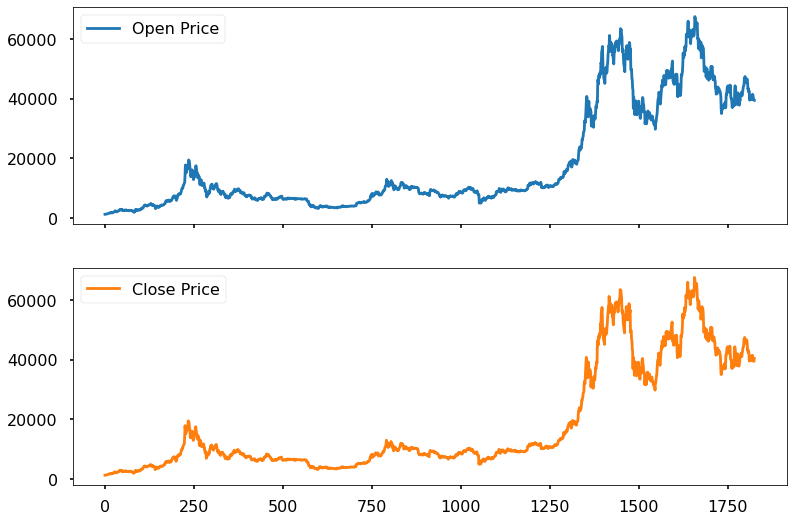

In [90]:
df1 = df[['Open Price', 'Close Price']]
df1.plot(subplots=True)

# RANDOM FOREST

PLEASE REVIEW CODE - THIS WAS ADAPTED BUT STILL need review

In [13]:
#import quantrautil as q
#import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [14]:
df.head(1)

,Date,Open Price,Close Price,Daily High,Daily Low,Volume,Adj Close
0,2017-04-26,1265.98999,1281.079956,1294.829956,1265.930054,329631008,1281.079956


def bollinger_strat(data, window, no_of_std):

  rolling_mean = data['Close'].rolling(window).mean()
  
  rolling_std = data['Close'].rolling(window).std()
  
  df['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)
  df['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)...

In [15]:
# Features construction 
df['Open-Close'] = df['Open Price'] - df['Close Price']/df['Open Price']
df['High-Low'] = df['Daily High'] - df['Daily Low']/df['Daily Low']
df['percent_change'] = df['Adj Close'].pct_change()
df['std_5'] = df['percent_change'].rolling(5).std()
df['ret_5'] = df['percent_change'].rolling(5).mean()
df.dropna(inplace=True)

# X is the input variable
X = df[['Open-Close', 'High-Low', 'std_5', 'ret_5']]

# Y is the target or output variable
y = np.where(df['Adj Close'].shift(-1) > df['Adj Close'], 1, -1)

In [16]:
# Total dataset length
dataset_length = df.shape[0]

# Training dataset length
split = int(dataset_length * 0.75)
split

1365

In [17]:
# Splitiing the X and y into train and test datasets
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Print the size of the train and test dataset
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1365, 4) (456, 4)
(1365,) (456,)


In [18]:
clf = RandomForestClassifier(random_state=5)

In [19]:
# Create the model on train dataset
model = clf.fit(X_train, y_train)

In [20]:
from sklearn.metrics import accuracy_score
print('Correct Prediction (%): ', accuracy_score(y_test, model.predict(X_test), normalize=True)*100.0)

Correct Prediction (%):  51.09649122807017


In [21]:
# Run the code to view the classification report metrics
from sklearn.metrics import classification_report
report = classification_report(y_test, model.predict(X_test))
print(report)

              precision    recall  f1-score   support

          -1       0.50      0.90      0.65       225
           1       0.58      0.13      0.21       231

    accuracy                           0.51       456
   macro avg       0.54      0.52      0.43       456
weighted avg       0.54      0.51      0.43       456



In [22]:
df['strategy_returns'] = df.percent_change.shift(-1) * model.predict(X)

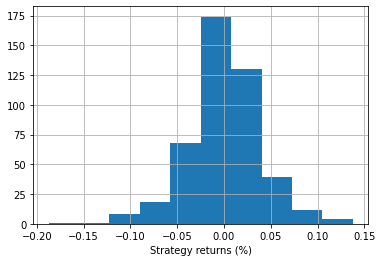

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
df.strategy_returns[split:].hist()
plt.xlabel('Strategy returns (%)')
plt.show()

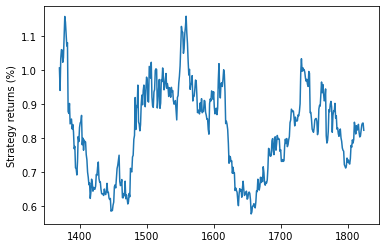

In [24]:
(df.strategy_returns[split:]+1).cumprod().plot()
plt.ylabel('Strategy returns (%)')
plt.show()

# Prediction XGBoost

In [126]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')
import math
import datetime as dt


from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns 
import matplotlib.pyplot as plt 
from colorama import Fore

In [127]:
bitcoindf=df

In [160]:
bitcoindf.head(1)

,Date,Open Price,Close Price,Daily High,Daily Low,Volume,Adj Close
0,2017-04-26,1265.98999,1281.079956,1294.829956,1265.930054,329631008,1281.079956


In [161]:
bitcoindf.Date.unique()

array(['2017-04-26T00:00:00.000000000', '2017-04-27T00:00:00.000000000',
       '2017-04-28T00:00:00.000000000', ...,
       '2022-04-23T00:00:00.000000000', '2022-04-24T00:00:00.000000000',
       '2022-04-25T00:00:00.000000000'], dtype='datetime64[ns]')

In [162]:
bitcoindf= bitcoindf.fillna(method = 'ffill')
#dogecoindf = dogecoindf.fillna(method = 'ffill')
#ethereumdf = ethereumdf.fillna(method = 'ffill')
#cardanodf = cardanodf.fillna(method = 'ffill')

In [163]:
bitcoindf['Date'] = pd.to_datetime(bitcoindf.Date)
bitcoindf.head().style.set_properties(subset=['Date','Close Price'], **{'background-color': 'skyblue'})

,Date,Open Price,Close Price,Daily High,Daily Low,Volume,Adj Close
0,2017-04-26 00:00:00,1265.989990,1281.079956,1294.829956,1265.930054,329631008,1281.079956
1,2017-04-27 00:00:00,1281.880005,1317.729980,1319.699951,1281.300049,449196992,1317.729980
2,2017-04-28 00:00:00,1317.739990,1316.479980,1331.280029,1292.369995,527488992,1316.479980
3,2017-04-29 00:00:00,1317.839966,1321.790039,1327.199951,1315.209961,422705984,1321.790039
4,2017-04-30 00:00:00,1321.869995,1347.890015,1347.910034,1314.920044,413115008,1347.890015


Text(0.5, 1.0, 'Bitcoin Close Price')

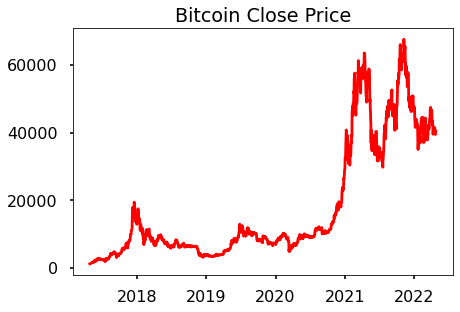

In [164]:
fig = plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(bitcoindf['Date'], bitcoindf['Close Price'], color="red")
plt.title('Bitcoin Close Price')

#plt.subplot(2, 2, 2)
#plt.plot(cardanodf['date'], cardanodf['close'], color="black")
#plt.title('Cardano Close Price')

#plt.subplot(2, 2, 3)
#plt.plot(dogecoindf['date'], dogecoindf['close'], color="orange")
#plt.title('Dogecoin Close Price')

#plt.subplot(2, 2, 4)
#plt.plot(ethereumdf['date'], ethereumdf['close'], color="green")
#plt.title('Ethereum Close Price')

In [165]:
last1year_bitcoindf = bitcoindf[bitcoindf['Date'] > '09-2020']
#last1year_cardanodf = cardanodf[cardanodf['date'] > '09-2020']
#last1year_dogecoindf = dogecoindf[dogecoindf['date'] > '09-2020']
#last1year_ethereumdf = ethereumdf[ethereumdf['date'] > '09-2020']

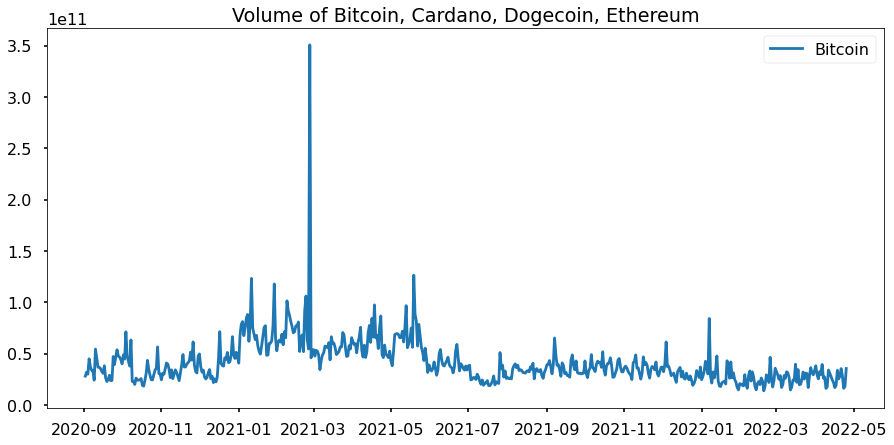

In [166]:
fig = plt.figure(figsize = (15,7))

plt.plot(last1year_bitcoindf['Date'] , last1year_bitcoindf['Volume'])
#plt.plot(last1year_cardanodf['date'] , last1year_cardanodf['volume'])
#plt.plot(last1year_dogecoindf['date'], last1year_dogecoindf['volume'])
#plt.plot(last1year_ethereumdf['date'], last1year_ethereumdf['volume'])
plt.title('Volume of Bitcoin, Cardano, Dogecoin, Ethereum')
plt.legend(['Bitcoin', 'Cardano', 'Dogecoin', 'Ethereum'])

In [167]:
last1month_bitcoindf = bitcoindf[bitcoindf['Date'] > '09-2021']
#last1month_cardanodf = cardanodf[cardanodf['date'] > '08-2021']
#last1month_dogecoindf = dogecoindf[dogecoindf['date'] > '08-2021']
#last1month_ethereumdf = ethereumdf[ethereumdf['date'] > '08-2021']

Text(0.5, 1.0, 'Bitcoin')

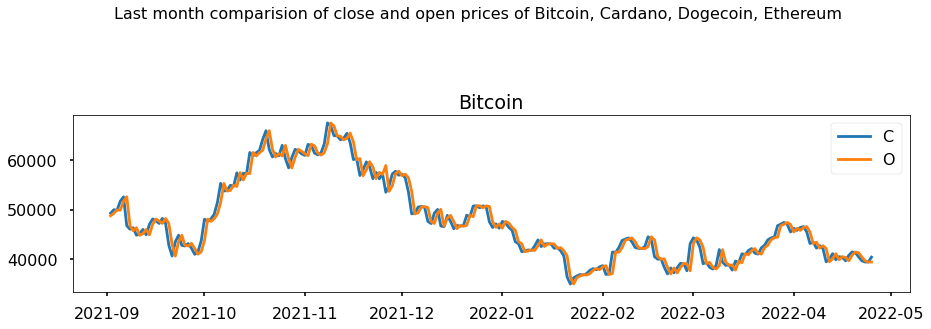

In [168]:
fig = plt.figure(figsize = (15,15))
fig.suptitle("Last month comparision of close and open prices of Bitcoin, Cardano, Dogecoin, Ethereum", fontsize=16)
fig.tight_layout()

plt.subplot(4, 1, 1)
plt.plot(last1month_bitcoindf['Date'], last1month_bitcoindf['Close Price'])
plt.plot(last1month_bitcoindf['Date'], last1month_bitcoindf['Open Price'])
plt.legend(["C", "O"])
plt.title("Bitcoin")

#plt.subplot(4, 1, 2)
#plt.plot(last1month_cardanodf['date'], last1month_cardanodf['close'], color="black")
#plt.plot(last1month_cardanodf['date'], last1month_cardanodf['open'], color="grey")
#plt.legend(["C", "O"])
#plt.title("Cardano")

#plt.subplot(4, 1, 3)
#plt.plot(last1month_dogecoindf['date'], last1month_dogecoindf['close'], color="orange")
#plt.plot(last1month_dogecoindf['date'], last1month_dogecoindf['open'], color="green")
#plt.legend(["C", "O"])
#plt.title("Dogecoin")

#plt.subplot(4, 1, 4)
#plt.plot(last1month_ethereumdf['date'], last1month_ethereumdf['close'], color="blue")
#plt.plot(last1month_ethereumdf['date'], last1month_ethereumdf['open'], color="yellow")
#plt.legend(["C", "O"])
#plt.title("Ethereum")


Text(0.5, 1.0, 'Bitcoin Close Price moving average')

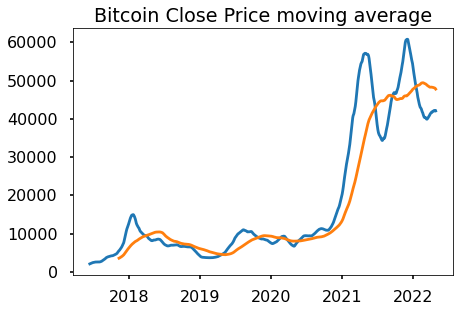

In [169]:
fig = plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(bitcoindf['Date'], bitcoindf['Close Price'].rolling(50).mean())
plt.plot(bitcoindf['Date'], bitcoindf['Close Price'].rolling(200).mean())
plt.title('Bitcoin Close Price moving average')

#plt.subplot(2, 2, 2)
#plt.plot(cardanodf['date'], cardanodf['close'].rolling(50).mean(), color="black")
#plt.plot(cardanodf['date'], cardanodf['close'].rolling(200).mean(), color="red")
#plt.title('Cardano Close Price moving average')

#plt.subplot(2, 2, 3)
#plt.plot(dogecoindf['date'], dogecoindf['close'].rolling(50).mean(), color="orange")
#plt.plot(dogecoindf['date'], dogecoindf['close'].rolling(200).mean(), color="grey")
#plt.title('Dogecoin Close Price moving average')

#plt.subplot(2, 2, 4)
#plt.plot(ethereumdf['date'], ethereumdf['close'].rolling(50).mean(), color="green")
#plt.plot(ethereumdf['date'], ethereumdf['close'].rolling(200).mean(), color="blue")
#plt.title('Ethereum Close Price moving average')
#Text(0.5, 1.0, 'Ethereum Close Price moving average')


Text(50000, 400, 'Bitcoin Close Price')

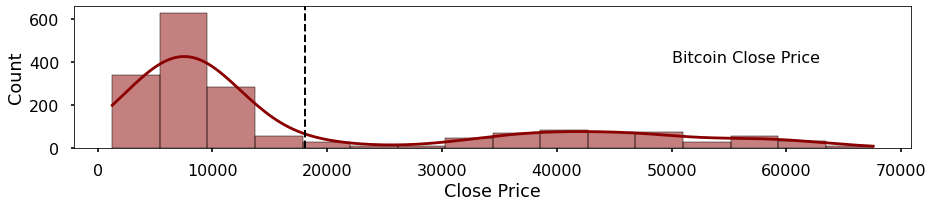

In [170]:
fig = plt.figure(figsize = (15,12))

fig.tight_layout()

plt.subplot(4, 1, 1)
sns.histplot(bitcoindf['Close Price'],color='darkred', kde=True)
plt.axvline(bitcoindf['Close Price'].mean(), color='k', linestyle='dashed', linewidth=2)
plt.text(50000,400,'Bitcoin Close Price', fontsize=16)

#plt.subplot(4, 1, 2)
#sns.histplot(cardanodf['close'],color='darkgreen', kde=True)
#plt.axvline(cardanodf['close'].mean(), color='k', linestyle='dashed', linewidth=2)
#plt.text(2.3,200,'Cardano Close Price', fontsize=16)

#plt.subplot(4, 1, 3)
#sns.histplot(dogecoindf['close'],color='grey', kde=True)
#plt.axvline(dogecoindf['close'].mean(), color='k', linestyle='dashed', linewidth=2)
#plt.text(0.52,200,'Dogecoin Close Price', fontsize=16)

#plt.subplot(4, 1, 4)
#sns.histplot(ethereumdf['close'],color='darkorange', kde=True)
#plt.axvline(ethereumdf['close'].mean(), color='k', linestyle='dashed', linewidth=2)
#plt.text(3100,400,'Ethereum Close Price', fontsize=16)

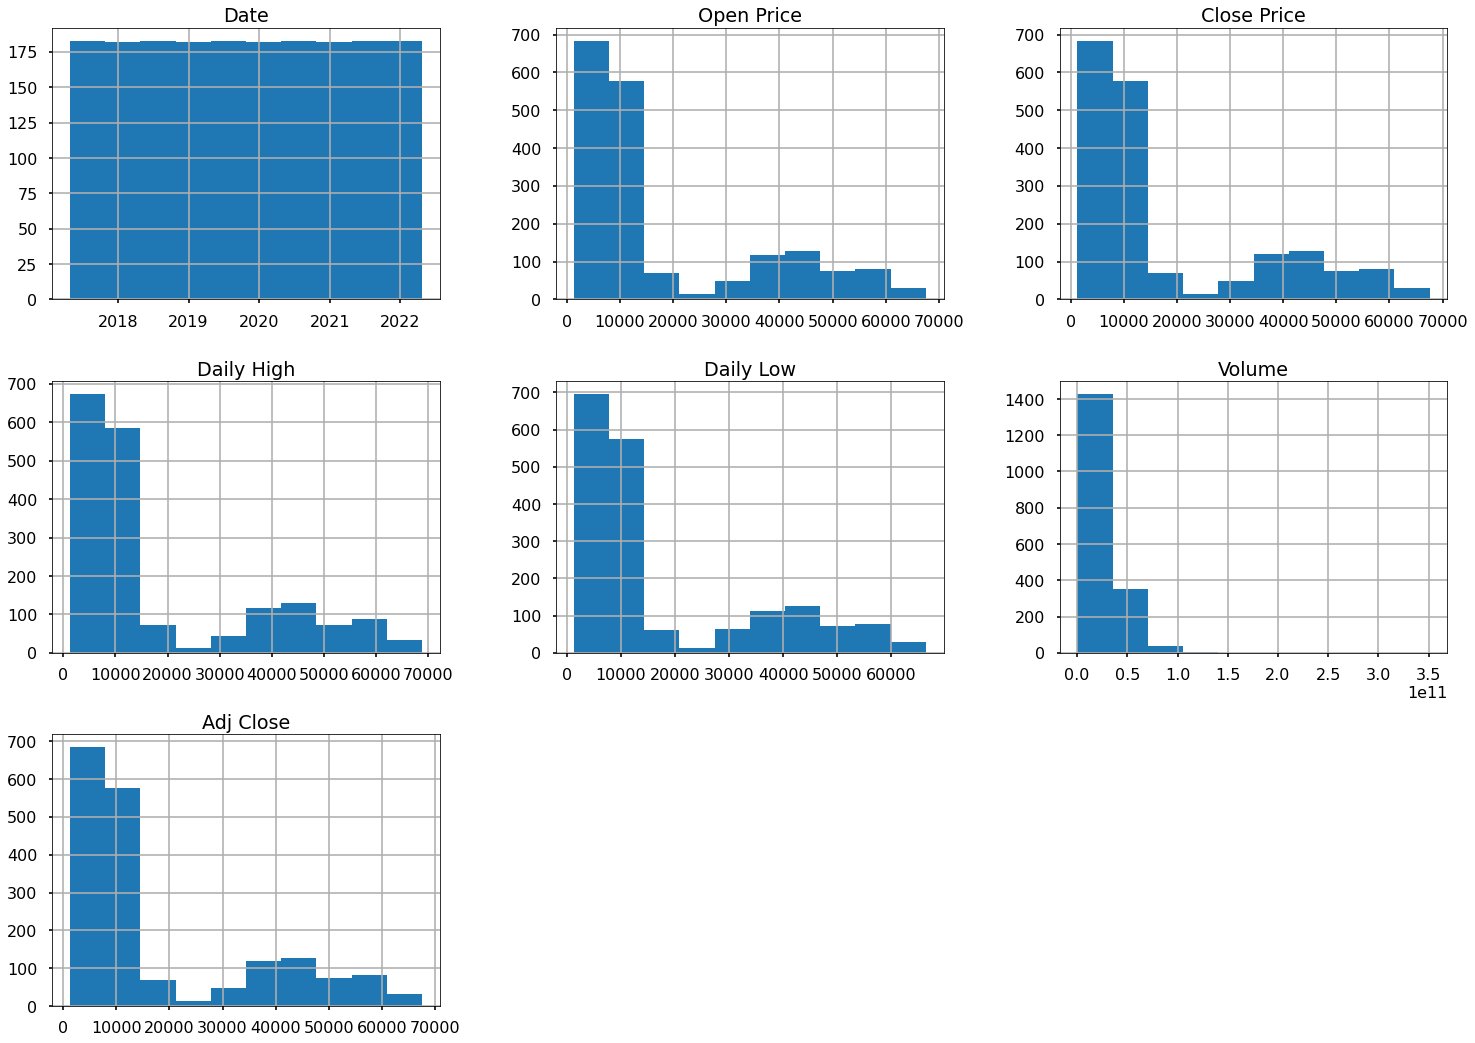

In [171]:
bitcoin_numeric = bitcoindf.select_dtypes(exclude = ["bool"])
bitcoin_numeric.hist(figsize=(25,18))
plt.show()

In [172]:
closedf = bitcoindf[['Date','Close Price']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (1826, 2)


In [173]:
closedf = closedf[closedf['Date'] > '2021-04-25']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  365


In [174]:
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(365, 1)


In [175]:
training_size=int(len(closedf)*0.70)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (255, 1)
test_data:  (110, 1)


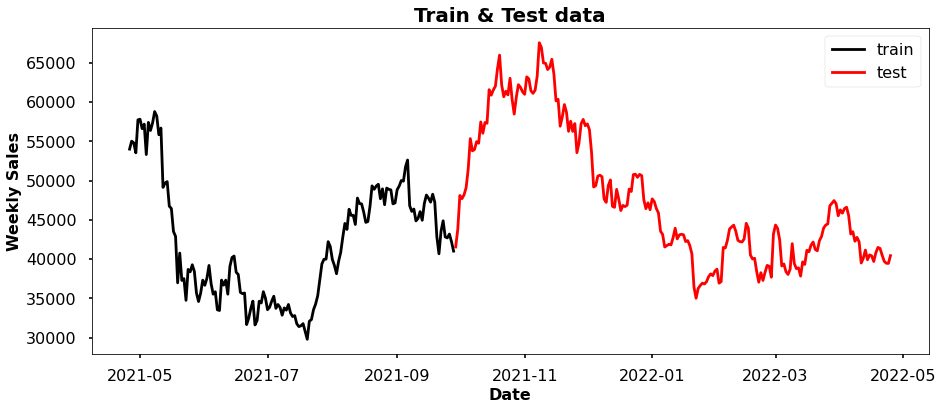

In [176]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = close_stock['Date'][:156], y = close_stock['Close Price'][:156], color = 'black')
sns.lineplot(x = close_stock['Date'][156:], y = close_stock['Close Price'][156:], color = 'red')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))


In [177]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [178]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (239, 15)
y_train:  (239,)
X_test:  (94, 15)
y_test (94,)


In [179]:
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, ...)

In [180]:
predictions = my_model.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.04026562129838605
Root Mean squared Error - RMSE : 0.05354817242473737


In [181]:
train_predict=my_model.predict(X_train)
test_predict=my_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (239, 1)
Test data prediction: (94, 1)


In [182]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [183]:
#shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close Price'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Close price','date': 'Date'})


fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (365, 1)
Test predicted data:  (365, 1)


In [184]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = my_model.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = my_model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))


Output of predicted next days:  10


In [185]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [188]:
import os

In [189]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Close price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
#plt.savefig(os.path.join('numeric_variables_boxplots.png'), dpi=200)
fig.show()

<Figure size 921.6x633.6 with 0 Axes>

In [190]:
my_model=closedf.tolist()
my_model.extend((np.array(lst_output).reshape(-1,1)).tolist())
my_model=scaler.inverse_transform(my_model).reshape(1,-1).tolist()[0]

names = cycle(['Close Price'])

fig = px.line(my_model,labels={'value': 'Close price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [50]:
ethereumdf
dogecoindf
cardanodf

NameError: name 'ethereumdf' is not defined

In [ ]:
bitcoindf = pd.read_excel("btc_usd.xlsx", sheet_name="btc_usd")


In [ ]:
df = pd.read_excel("eth_usd.xlsx", sheet_name="eth_usd")


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
),
         go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            ),
        ]
    ,layout=layout)


fig.update_layout(
    title = f'The Candlestick graph for ETH-USD',
    xaxis_title = 'Date',
    yaxis_title = f'ETH-USD',
    xaxis_rangeslider_visible = True #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')


fig.show()

In [ ]:
df = df[['Open Price', 'Close Price']]
df.plot(subplots=True)

In [ ]:
df = pd.read_excel("ada_usd.xlsx", sheet_name="ada_usd")


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
),
         go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            ),
        ]
    ,layout=layout)


fig.update_layout(
    title = f'The Candlestick graph for ADA-USD',
    xaxis_title = 'Date',
    yaxis_title = f'ADA-USD',
    xaxis_rangeslider_visible = True #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')


fig.show()

In [ ]:
df = df[['Open Price', 'Close Price']]
df.plot(subplots=True)

In [ ]:
df = pd.read_excel("atom_usd.xlsx", sheet_name="atom_usd")


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
),
         go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            ),
        ]
    ,layout=layout)


fig.update_layout(
    title = f'The Candlestick graph for ATOM-USD',
    xaxis_title = 'Date',
    yaxis_title = f'ATOM-USD',
    xaxis_rangeslider_visible = True #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')


fig.show()

In [ ]:
df = df[['Open Price', 'Close Price']]
df.plot(subplots=True)

In [ ]:
df = pd.read_excel("avax_usd.xlsx", sheet_name="avax_usd")


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
),
         go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            ),
        ]
    ,layout=layout)


fig.update_layout(
    title = f'The Candlestick graph for AVAX-USD',
    xaxis_title = 'Date',
    yaxis_title = f'AVAX-USD',
    xaxis_rangeslider_visible = True #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')


fig.show()

In [ ]:
df = df[['Open Price', 'Close Price']]
df.plot(subplots=True)

In [ ]:
df = pd.read_excel("axs_usd.xlsx", sheet_name="axs_usd")


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
),
         go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            ),
        ]
    ,layout=layout)


fig.update_layout(
    title = f'The Candlestick graph for AXS-USD',
    xaxis_title = 'Date',
    yaxis_title = f'AXS-USD',
    xaxis_rangeslider_visible = True #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')


fig.show()

In [ ]:
df = df[['Open Price', 'Close Price']]
df.plot(subplots=True)

In [ ]:
df = pd.read_excel("luna_usd.xlsx", sheet_name="luna_usd")


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
),
         go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            ),
        ]
    ,layout=layout)


fig.update_layout(
    title = f'The Candlestick graph for LUNA-USD',
    xaxis_title = 'Date',
    yaxis_title = f'LUNA-USD',
    xaxis_rangeslider_visible = True #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')


fig.show()

In [ ]:
df = df[['Open Price', 'Close Price']]
df.plot(subplots=True)

In [ ]:
df = pd.read_excel("matic_usd.xlsx", sheet_name="matic_usd")


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
),
         go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            ),
        ]
    ,layout=layout)


fig.update_layout(
    title = f'The Candlestick graph for MATIC-USD',
    xaxis_title = 'Date',
    yaxis_title = f'MATIC-USD',
    xaxis_rangeslider_visible = True #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')


fig.show()

In [ ]:
df = pd.read_excel("sol_usd.xlsx", sheet_name="sol_usd")


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
),
         go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            ),
        ]
    ,layout=layout)


fig.update_layout(
    title = f'The Candlestick graph for SOL-USD',
    xaxis_title = 'Date',
    yaxis_title = f'SOL-USD',
    xaxis_rangeslider_visible = True #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')


fig.show()

In [ ]:
df = pd.read_excel("link_usd.xlsx", sheet_name="link_usd")


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
),
         go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = df["Date"], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            ),
        ]
    ,layout=layout)


fig.update_layout(
    title = f'The Candlestick graph for LINK-USD',
    xaxis_title = 'Date',
    yaxis_title = f'LINK-USD',
    xaxis_rangeslider_visible = True #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')


fig.show()

In [ ]:
df = df[['Open Price', 'Close Price']]
df.plot(subplots=True)

In [ ]:
def cor_heatmap(cor):
    plt.figure(figsize=(20,20))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Blues, fmt='.1')
    plt.show()
    

In [ ]:
cor_heatmap(np.round(close_price[all_pairs].corr(method = "spearman"),3)) #######I AM NOT SURE WHICH TO USE PEARSON OR SPEARMAN (HAD LESS DIVERGENCE OF VALUES WITH PEARSON)

In [ ]:
fig = go.Figure(
layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
))


    # Scatter
for idx, name in enumerate(close_price):
    fig = fig.add_trace(
        go.Scatter(
            x = close_price.index,
            y = close_price[name],
            name = name,
        )
    )
fig.update_layout(
    title = 'The Correlation between Different Cryptocurrencies',
    xaxis_title = 'Date',
    yaxis_title = f'Price',
    legend_title = 'Cryptocurrencies'
)
fig.update_yaxes(type='log', tickprefix='$')
fig.show()

In [ ]:
crypto.head(1).T